<center 
style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:35px; font-size:400%; text-align:center;padding:3.0px; background: #17202a; border-top: 13px solid #f5b041; border-bottom: 10px solid #f5b041; border-left: 10px solid #17202a; border-right: 10px solid #17202a">  Predict Calorie Expenditure
<img src="https://www.kaggle.com/competitions/91716/images/header" width="300" style="border: 1px solid #17202a; border-radius: 30px" loading="lazy" /> 
</center>

<p 
style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#17202a; border-radius:35px; font-size:200%; text-align:center;padding:3.0px; background: #f0eace; border-top: 13px solid #f5b041; border-bottom: 10px solid #f5b041; border-left: 10px solid #f5b041; border-right: 10px solid #f5b041" >  The Evaluation is done with Root Mean Squared Logarithmic Error:
        <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRKAYI5FzuZFJfVeys-Ypx0CA9x96k78sabJA&s" width="300" style="border: 1px solid #17202a; border-radius: 30px" loading="lazy" /> 
</p>

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > Our Target </p>

In [1]:
target = 'Calories'

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 1. Load Tools </p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn .metrics import r2_score, mean_squared_log_error, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (train_test_split, GridSearchCV, KFold, RepeatedKFold,
                                     RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score,
                                     StratifiedKFold, TimeSeriesSplit as TSS)

import sklearn
from sklearn.preprocessing import (MaxAbsScaler, MinMaxScaler, Normalizer, minmax_scale, 
                                   PowerTransformer, QuantileTransformer, LabelEncoder,
                                   RobustScaler, StandardScaler, FunctionTransformer,
                                   LabelEncoder, OneHotEncoder, OrdinalEncoder)

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance, cv
from sklearn.compose import make_column_transformer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

import optuna

import warnings
warnings.filterwarnings('ignore')

# verify the versions of my tools
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'sklearn version: {sklearn.__version__}')
# print(f'optuna version : {optuna.__version__}')

pandas version: 2.2.3
numpy version: 1.26.4
seaborn version: 0.12.2
sklearn version: 1.2.2


# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 2. Define the Metrics </p>

In [3]:
def rmsle(y_true, y_pred):
    # Ensure the inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the logarithm of the true and predicted values
    log_true = np.log1p(y_true+1)
    log_pred = np.log1p(y_pred+1)
    
    # Calculate the squared differences
    squared_diff = np.square(log_true - log_pred)
    
    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate the root of the mean squared differences
    rmsle_value = np.sqrt(mean_squared_diff)
    
    return rmsle_value


# Define RMSLE metric
def rmsle_metric(y_true, y_pred):
    y_true = np.maximum(y_true, 1e-6)  # Avoid log(0) issues
    y_pred = np.maximum(y_pred, 1e-6)

    log_true = np.log(y_true)
    log_pred = np.log(y_pred)

    rmsle = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return rmsle

# Train model using a custom metric
model = CatBoostRegressor(
    verbose=250,
    custom_metric=rmsle_metric,  # This won't affect optimization but will be displayed
    eval_metric="RMSE"  # You must set an optimization metric separately
)

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" >  3. Load and Preview the Data </p>

In [4]:
train_raw = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv', index_col='id')
test_raw = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv', index_col='id')
orig_raw = pd.read_csv('/kaggle/input/calories-burnt-prediction/calories.csv').drop(columns=['User_ID'])

orig_raw.columns = train_raw.columns
train_raw.head(3)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0


# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 4. Data pre-Treatment </p>

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" >  4.1 Define the Features Engineering Tool </p>

In [5]:
class Feature_Eng(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        df['Max_heart_rate'] = 207 - 0.7*df['Age']
        df['%_heart_rate'] = df['Heart_Rate']/df['Max_heart_rate']
        # df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 60, 100], labels=[1, 2, 3, 4])
        df['Age_pred_max_heart_rate'] = pd.cut(df['Age'], 
                                               bins=[10, 30, 35, 40, 45, 50, 55, 60, 65, 70, 90], 
                                               labels=[200, 190, 185, 180, 175, 170, 165, 160, 155, 150]
                                              ).astype('int')
        df['diff_heart_rate'] = df['Max_heart_rate'] - df['Age_pred_max_heart_rate']
        df = df.drop(columns=['Age'])
        df['BMI'] = df['Weight']/(0.01*df['Height'])**2
        # df['Temp_Weight_ratio'] = df['Body_Temp']/df['Weight']
        # df['HeartRate_BodyTemp_ratio'] = df['Heart_Rate']/df['Body_Temp']
        df['is_male'] = df['Sex'].map({'male':1, 'female':0})
        # df['is_male'] = df['Sex']=='male'
        df = df.drop(columns=['Sex'])
            
        return df

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 4.2 How correlated are the features? </p>

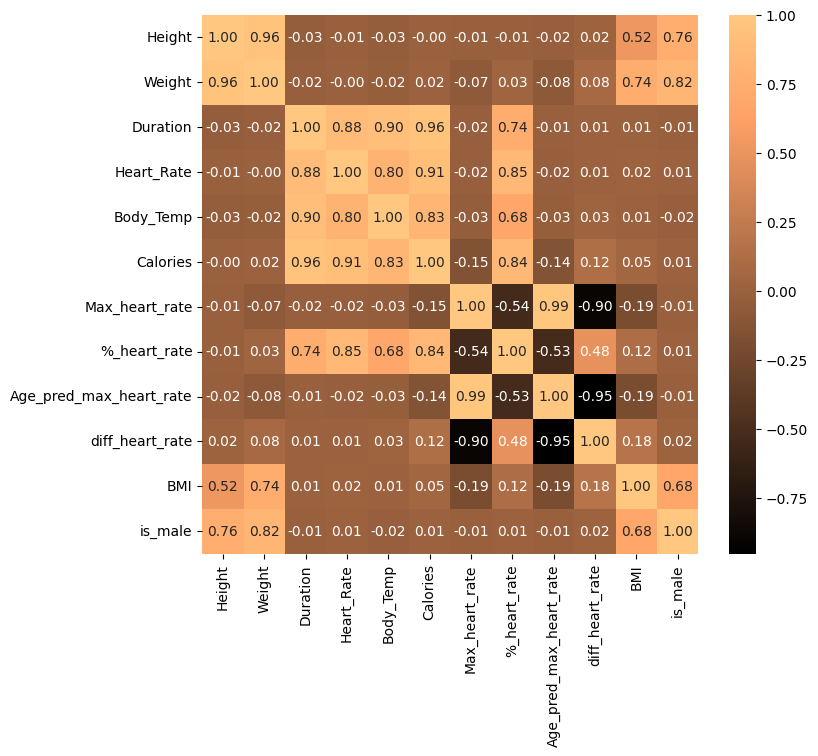

In [6]:
prep_X = train_raw.copy()
prep_X = Feature_Eng().fit_transform(prep_X)

plt.figure(figsize=(8, 7))
prep_corr = prep_X.corr()
sns.heatmap(prep_corr, annot=True, fmt='.2f', cmap='copper');

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 4.3 Define Correlation Feature Selector </p>

In [7]:
class DHCF(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        return self

    def transform(self, df, threshold=0.98):
        # Calculate the correlation matrix
        corr_matrix = df.corr().abs()
        # Select the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Initialize a set to keep track of features to drop
        to_drop = set()
        
        # Iterate over the columns and find features with correlation greater than the threshold
        for column in upper.columns:
            if any(upper[column] > threshold):
                # Add the column to the set of features to drop
                to_drop.add(column)
                # Remove the correlated columns from further consideration
                correlated_columns = upper.index[upper[column] > threshold].tolist()
                to_drop.update(correlated_columns)
        
        # Drop the features from the dataset
        df.drop(to_drop, axis=1, inplace=True)
    
        return df

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 4.4 Preview the treated data </p>

In [8]:
prep_X = train_raw.copy()
prep_X.pop(target)

prep_treator = make_pipeline(Feature_Eng(), DHCF())
prep_X = prep_treator.fit_transform(prep_X)

num_feats = prep_X.select_dtypes(include='number').columns.tolist()

prep_X.head()

,Height,Weight,Duration,Heart_Rate,Body_Temp,%_heart_rate,diff_heart_rate,BMI,is_male
id,,,,,,,,,
0,189.0,82.0,26.0,101.0,41.0,0.555556,-3.2,22.955684,1
1,163.0,60.0,8.0,85.0,39.7,0.524044,2.2,22.582709,0
2,161.0,64.0,7.0,84.0,39.8,0.490368,1.3,24.690405,0
3,192.0,90.0,25.0,105.0,40.7,0.544041,-7.0,24.414062,1
4,166.0,61.0,25.0,102.0,40.6,0.565410,-4.6,22.136740,0


# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5. Modeling </p>


## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.1 Define the column transformer </p>

In [9]:
# # List of features needing scaling
# feat_to_scale = ['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 
#                  'Max_heart_rate', 'Age_pred_max_heart_rate', 'BMI']

feat_to_scale = num_feats

# Build my feature transformer
column_trans = make_column_transformer(
    # (RobustScaler(), num_feats), 
    (MinMaxScaler(), feat_to_scale), 
    remainder='passthrough', 
    sparse_threshold=0)

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.2 Separet data from target </p>

In [10]:
train_data = pd.concat([train_raw, orig_raw], ignore_index=True, axis=0)

X = train_raw.copy()
y = X.pop(target)

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.3 Optimization of the Estimators </p>

### <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.3.1 Optimization of XGBRegressor </p>

In [11]:
# Ensure X and y are defined externally
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function
def objective_xgb(trial):
    xgb_param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),  # L2 regularization
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    # Data preprocessing and model initialization
    model = make_pipeline(Feature_Eng(), 
                          # DHCF(), 
                          column_trans, 
                          XGBRegressor(**xgb_param_grid))

    # model = make_pipeline(Feature_Eng(), XGBRegressor(**xgb_param_grid))

    # fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model using RMSE
    try:
        preds = model.predict(X_val)
        score = rmsle(y_val, preds)
        return score
    except:
        return 100

# Define the function to run the study
def Run_Pass_xgb_study(n_trials=1):
    if n_trials > 1:
        # Create and run the study
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_xgb, n_trials=n_trials, 
                       show_progress_bar=True)
        best_study_params = study.best_params

        # Print results
        print(f"Number of finished trials: {len(study.trials)}")
        trial = study.best_trial
        print(f"Best trial RMSE score: {trial.value:.6f}")
    else:
        print("No need to run Optuna, we will use the parameters obtained earlier.")       
        best_study_params = {'n_estimators': 560, 
                             'learning_rate': 0.020870346769912278, 
                             'max_depth': 13, 
                             'subsample': 0.5577817127649578, 
                             'colsample_bytree': 0.9994435195680964, 
                             'reg_alpha': 7.440704103081108, 
                             'reg_lambda': 1.64208528989806, 
                             'min_child_weight': 7}

    print(f"Best parameters: {best_study_params}")
    return best_study_params

xgb_best_params = Run_Pass_xgb_study(1)

No need to run Optuna, we will use the parameters obtained earlier.
Best parameters: {'n_estimators': 560, 'learning_rate': 0.020870346769912278, 'max_depth': 13, 'subsample': 0.5577817127649578, 'colsample_bytree': 0.9994435195680964, 'reg_alpha': 7.440704103081108, 'reg_lambda': 1.64208528989806, 'min_child_weight': 7}


### <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.3.2 Optimization of CatBoostRegressor </p>

In [12]:
def objective(trial):
    cat_param_grid = {
        "iterations": trial.suggest_int("iterations", 100, 1000, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        # "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1),
        "random_strength": trial.suggest_float("random_strength", 0.1, 0.7),
        "depth": trial.suggest_int("depth", 1, 10),
        # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "boosting_type": "Plain",
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "5gb",
    }

    if cat_param_grid["bootstrap_type"] == "Bayesian":
        cat_param_grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 1)
    elif cat_param_grid["bootstrap_type"] == "Bernoulli":
        cat_param_grid["subsample"] = trial.suggest_float("subsample", 0.5, 1)

    # Train the model
    cat_estimator = CatBoostRegressor(**cat_param_grid, verbose=0)
    model = make_pipeline(Feature_Eng(), 
                          # DHCF(), 
                          column_trans, 
                          cat_estimator)
    
    # X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=8)
    # X_train_pool = Pool(X_train, y_train)#, cat_features=['day_bins'])
    # X_valid_pool = Pool(X_val, y_val)#, cat_features=['day_bins'])
    
    # model.fit(X_train_pool)
    # model.fit(X=X_train_pool, 
    #       eval_set=X_valid_pool, 
    #       verbose=0, 
    #       early_stopping_rounds=100)
    # val_pred = model.predict_proba(X_valid_pool)[:, 1]
    # score = roc_auc_score(y_val, val_pred)
    # return score

        # fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model using RMSE
    try:
        preds = model.predict(X_val)
        score = rmsle(y_val, preds)
        return score
    except:
        return 100

def Run_Pass_cat_study(n_trials=1):
    if n_trials>1:
        # Create and run the study
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, timeout=36000, show_progress_bar=True)
        best_study_params = study.best_params
        # Print the best trial
        print('Number of finished trials: {}'.format(len(study.trials)))
        trial = study.best_trial
        print('Best trial auc_score: {:.6f}'.format(trial.value))

    else:
        print('No need to run optuna, we will use the parameters obtained earlier')
        best_study_params = {'iterations': 380,
                                'learning_rate': 0.02994469538378683,
                                'objective': 'Logloss',
                                'colsample_bylevel': 0.8704558522886159,
                                'random_strength': 0.6467195903372872,
                                'depth': 8,
                                'bootstrap_type': 'Bernoulli',
                                'subsample': 0.8301544244176395}
    
    print('best params: {}'.format(best_study_params))
    return best_study_params

cat_best_params = Run_Pass_cat_study(100)

[I 2025-05-03 20:22:44,276] A new study created in memory with name: no-name-9ed11992-3b48-4640-852d-e9865aad7d6e


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2025-05-03 20:22:56,063] Trial 0 failed with parameters: {'iterations': 960, 'learning_rate': 0.29364226521814296, 'colsample_bylevel': 0.5581708047049032, 'random_strength': 0.24047131784994902, 'depth': 1, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5469423527500271} because of the following error: The value nan is not acceptable.
[W 2025-05-03 20:22:56,064] Trial 0 failed with value nan.
[I 2025-05-03 20:23:10,102] Trial 1 finished with value: 0.05837959142289517 and parameters: {'iterations': 280, 'learning_rate': 0.44288456918796104, 'colsample_bylevel': 0.9317698514348562, 'random_strength': 0.6920687602833585, 'depth': 8, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.43963918074185626}. Best is trial 1 with value: 0.05837959142289517.
[I 2025-05-03 20:23:39,553] Trial 2 finished with value: 0.058632729385337604 and parameters: {'iterations': 950, 'learning_rate': 0.3597713885928024, 'colsample_bylevel': 0.4791358964503969, 'random_strength': 0.2494611812362157, 'de

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.4 Define the Regressor Pipeline </p>

### <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.4.1 Define the estimator </p>

In [13]:
# Choice of the estimator
model = 'cat'

if model=='cat':
    estimator = CatBoostRegressor(**cat_best_params,
                                  verbose=500, 
                                  eval_metric='R2', 
                                  eval_fraction=0.2, 
                                  early_stopping_rounds=600)
elif model=='xgb':
    estimator = XGBRegressor(**xgb_best_params)
elif model=='lgb':
    estimator = LGBMRegressor(verbose=-1)

### <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.4.2 Define the estimator pipeline </p>

In [14]:
pipeline_steps = [
                  ('eng', Feature_Eng()), 
                  ('high_corr_drop', DHCF()),
                  ('transformer', column_trans),
                  ('estimator', estimator)
               ]

reg = Pipeline(pipeline_steps)
reg

Pipeline(steps=[('eng', Feature_Eng()), ('high_corr_drop', DHCF()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp', '%_heart_rate',
                                                   'diff_heart_rate', 'BMI',
                                                   'is_male'])])),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x7efeda1970d0>)])

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 5.5 Cross validation </p>

0:	learn: 0.1022708	test: 0.1022894	best: 0.1022894 (0)	total: 49.3ms	remaining: 46.7s
500:	learn: 0.9970812	test: 0.9968538	best: 0.9968538 (500)	total: 25.5s	remaining: 22.9s
949:	learn: 0.9972858	test: 0.9968822	best: 0.9968822 (948)	total: 48.3s	remaining: 0us

bestTest = 0.9968822149
bestIteration = 948

Shrink model to first 949 iterations.

0:	learn: 0.1022848	test: 0.1022110	best: 0.1022110 (0)	total: 49.1ms	remaining: 46.6s
500:	learn: 0.9971209	test: 0.9967039	best: 0.9967040 (499)	total: 25.5s	remaining: 22.9s
949:	learn: 0.9973095	test: 0.9967357	best: 0.9967357 (944)	total: 47.8s	remaining: 0us

bestTest = 0.9967356859
bestIteration = 944

Shrink model to first 945 iterations.

0:	learn: 0.1022762	test: 0.1021487	best: 0.1021487 (0)	total: 78.3ms	remaining: 1m 14s
500:	learn: 0.9971002	test: 0.9967025	best: 0.9967025 (500)	total: 25.3s	remaining: 22.6s
949:	learn: 0.9973095	test: 0.9967277	best: 0.9967278 (888)	total: 48.2s	remaining: 0us

bestTest = 0.9967278228
bestItera

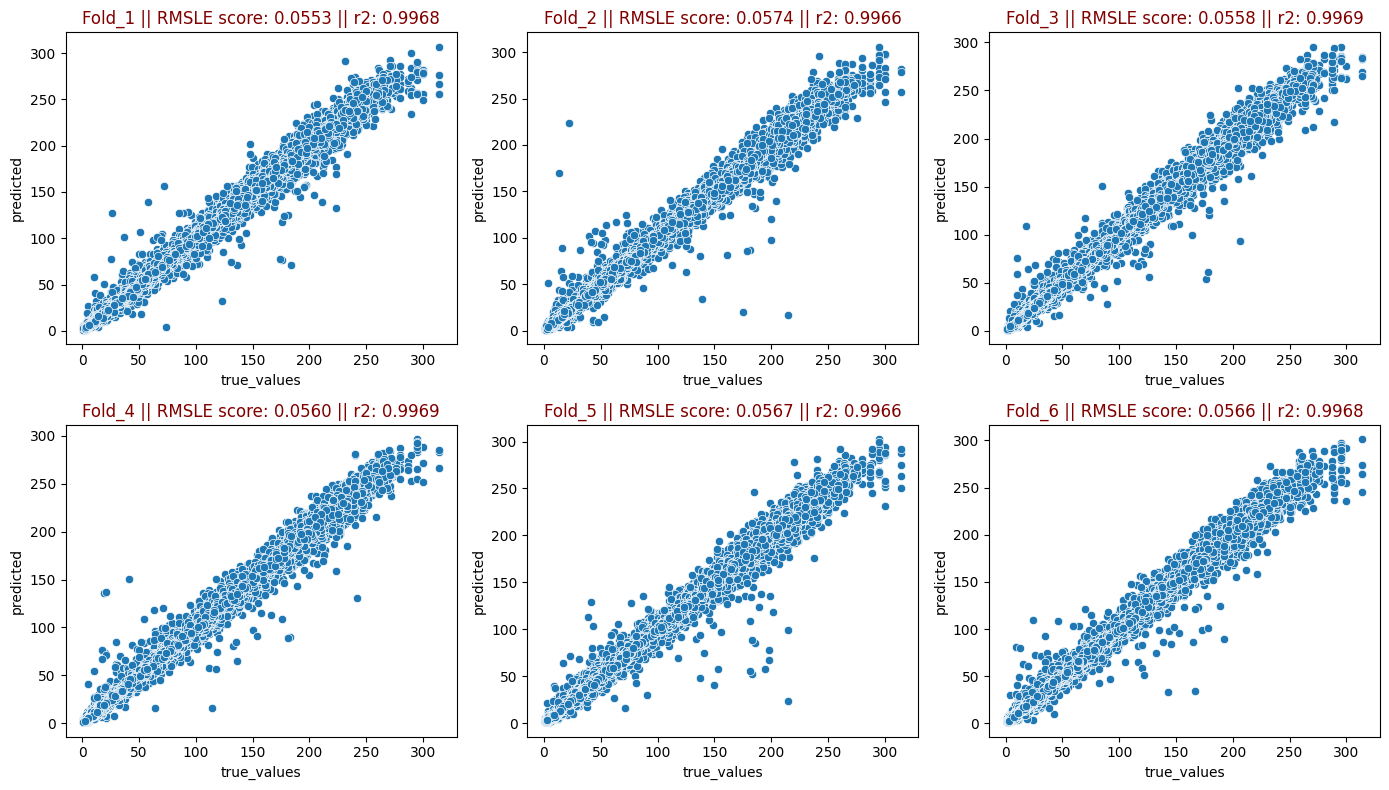

In [15]:
n = 6
spliter = KFold(n_splits=n, shuffle=True, random_state=15)

plt.figure(figsize=(14,8))
for f, (tr_ind, va_ind) in enumerate(spliter.split(X, y), start=1):
    X_tr, X_va = X.loc[tr_ind], X.loc[va_ind]
    y_tr, y_va = y.loc[tr_ind], y.loc[va_ind]
    # fit and predict for the fold
    reg.fit(X_tr, y_tr)
    y_va_hat = reg.predict(X_va)
    y_va_hat = np.clip(y_va_hat, orig_raw[target].min(), orig_raw[target].max())
    # score the prediction for the fold
    rmsle_score = rmsle(y_va, y_va_hat)
    r2 = r2_score(y_va, y_va_hat)
    print('')
    # plot a scatter plot to compare predicted vs true values
    plt.subplot(2,3,f)
    sns.scatterplot(x=y_va, y=y_va_hat)
    plt.title("Fold_{} || RMSLE score: {:.4f} || r2: {:.4}".format(f, rmsle_score, r2), color='maroon')
    plt.xlabel('true_values')
    plt.ylabel('predicted')
plt.tight_layout()

# <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 6. Use of the final model </p>

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 6.1 Define and fit the final model </p>

In [16]:
reg_final = Pipeline(pipeline_steps)

reg_final.fit(X, y)

0:	learn: 0.1022823	test: 0.1024457	best: 0.1024457 (0)	total: 58.4ms	remaining: 55.4s
500:	learn: 0.9970788	test: 0.9967006	best: 0.9967013 (498)	total: 29.8s	remaining: 26.7s
949:	learn: 0.9972676	test: 0.9967292	best: 0.9967292 (949)	total: 55.9s	remaining: 0us

bestTest = 0.9967292003
bestIteration = 949



Pipeline(steps=[('eng', Feature_Eng()), ('high_corr_drop', DHCF()),
                ('transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp', '%_heart_rate',
                                                   'diff_heart_rate', 'BMI',
                                                   'is_male'])])),
                ('estimator',
                 <catboost.core.CatBoostRegressor object at 0x7efeda1970d0>)])

## <p style= "font-family: Calibri; font-weight:bold; letter-spacing: 0px; color:#f5b041; border-radius:16px; font-size:100%; text-align:left;padding:3.0px; background: #17202a; border-bottom: 4px solid #f5b041; border-left: 6px solid #f5b041" > 6.2 Prediction on the test data </p>

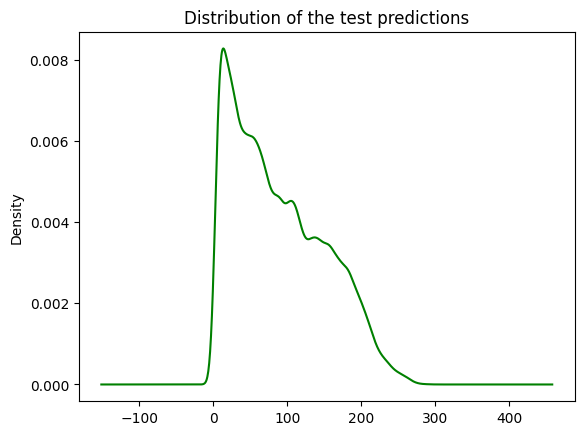

,id,Calories
0,750000,26.832405
1,750001,108.383905
2,750002,86.947345
3,750003,125.345085
4,750004,75.965102
5,750005,22.013461
6,750006,49.704479
7,750007,6.745953
8,750008,9.421464
9,750009,205.529820


The file is ready for submission!


In [17]:
test_pred = np.clip(reg_final.predict(test_raw), 
                    orig_raw[target].min(), 
                    orig_raw[target].max())

submission = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
submission[target] = test_pred

submission.to_csv('submission.csv', index=False)

submission[target].plot.kde(color='green', title='Distribution of the test predictions')
plt.show()

# Display the submission file
display(submission.head(10))
print('The file is ready for submission!')